# Interloper count

*24 Nov 2020*

A notebook to count how many interlopers of a given mass range we expect! (Made this notebook while mostly working in `~/ml-interlopers/`.)

*Copying some code from `plateau.ipynb`.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import units as u
from astropy import constants as c

from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d, interp2d
from scipy.misc import derivative

from helpers import sigma_cr

cosmo = FlatLambdaCDM(H0=67.5, Om0=0.316)
#cosmo = FlatLambdaCDM(H0=67.66 * u.km/u.s/u.Mpc, Om0=0.321) # Planck 2018 values
arcsec_in_rad = np.pi/648000

Define the mass range here:

In [2]:
z_low = .01 # for numerical reasons, sometimes we can't go all the way down to 0
z_lower = .001
m_low = 1e8 # in Msun
m_high = 1e10

In [3]:
def chi_to_z(chi):
    """Takes in `chi` as a number of kpc"""
    return z_at_value(cosmo.comoving_distance, chi*u.kpc, zmax=3.1)
def z_to_chi(z):
    """Returns chi as a number of kpc"""
    return cosmo.comoving_distance(z).to(u.kpc).value
chilist = np.linspace(z_to_chi(z_lower),z_to_chi(3),100)
zlist = [chi_to_z(chi) for chi in chilist]
chi_to_z_fast = interp1d(chilist, zlist)
z_to_chi_fast = interp1d(zlist, chilist)

## Sheth-Tormen

In [4]:
# Load ST results
h = .675
massesn = np.load('files/st_results/WIDE_massesn_ST.npy')
massfunc_mat = np.load('files/st_results/WIDE_massfunc_ST.npy') / 1000**3 # * h**3/1000**3
redshifts = np.load('files/st_results/WIDE_redshifts_ST.npy')

massfunc = interp2d(redshifts, massesn, massfunc_mat, bounds_error=True) # function of (z, mass)

`massfunc` corresponds to:
$$n(z, m).$$

## Double-cone radius

In [5]:
def double_cone_direct(com_z, com_l, com_s):
    # Input can be in any units
    if com_z < com_l:
        return com_z / com_l
    else:
        return (com_s - com_z) / (com_s - com_l)
    
def double_cone_zspace(z, zl, zs):
    return double_cone_direct(z_to_chi_fast(z), z_to_chi_fast(zl), z_to_chi_fast(zs))

Text(0, 0.5, 'Double cone radius (arb. units)')

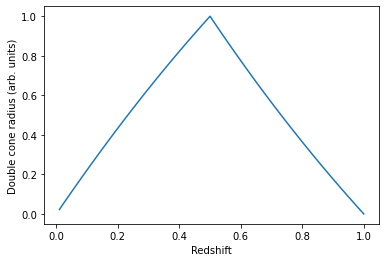

In [6]:
plot_zs = np.linspace(z_low,1,100)
plot_coms = z_to_chi_fast(plot_zs)
plt.plot(plot_zs, [double_cone_zspace(z, 0.5, 1) for z in plot_zs])
plt.xlabel('Redshift')
plt.ylabel('Double cone radius (arb. units)')

### Derivative $d\chi / dz$
We'll interpolate to save time while integrating

In [7]:
z_vals = np.linspace(1e-5,3,200)
dchi_dz_func = interp1d(z_vals, 1000*derivative(cosmo.comoving_distance, z_vals, dx=.00001)) # in terms of kpc (cosmo.comoving_distance was in Mpc)

In [8]:
## These two lines should give roughly the same answer (and they do)
# quad(dchi_dz_func, 0, 1)
# z_to_chi(1)

Text(0.5, 0, 'z')

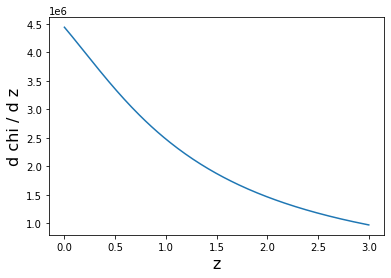

In [9]:
plt.plot(z_vals, dchi_dz_func(z_vals))
plt.ylabel('d chi / d z', size=16)
plt.xlabel('z', size=16)

## Integral

$$N = R_\mathrm{ref}^2 \int_0^{z_s} dz \frac{d\chi}{dz} \frac{R^2(z)}{R^2(z_\ell)} \int_{m_l}^{m_h} n(z,m) dm$$
where
- $N$ is the number per arcsec squared (I wrote radian squared earlier, but I think that was a mistake)
- $R_\mathrm{ref} = \chi_\ell \cdot \mathrm{arcsec}$ converts the integral from count per comoving area at $z_\ell$ to count per arcsec$^2$
- $n$ is the ST mass function

*No effective mass function*

Note that we could use the effective mass function to define the bounds of the mass integral, but since it does not affect the result much and for simplicity, we'll just skip it. Below (after Subhalo Count), we will redo this calculation accounting for the effective mass function and show that it gives a similar result.

### Mass integral

In [10]:
z_list = np.linspace(z_lower, 3 - z_lower, 20)
mass_integral_list = [quad(lambda m: massfunc(z,m), m_low, m_high, epsrel=1e-2)[0]
                      for z in z_list]
mass_integral_func = interp1d(z_list, mass_integral_list)

Text(0, 0.5, 'Number density of all masses in range (/comoving volume; units?)')

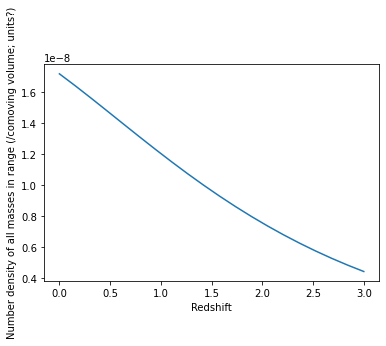

In [11]:
plt.plot(z_list, mass_integral_list)
plt.xlabel('Redshift')
plt.ylabel('Number density of all masses in range (/comoving volume; units?)') # per comoving kpc^3 I think?

### Rest of integral

In [12]:
def integrand(z, zl, zs):
    return dchi_dz_func(z) * double_cone_zspace(z, zl, zs)**2 * mass_integral_func(z)

def integral(zl, zs):
    rref = z_to_chi(zl) * arcsec_in_rad # one arcsec in comoving kpc (at the lens)
    return rref**2 * quad(lambda z: integrand(z, zl, zs), z_low, zs, epsrel=1e-2)[0]

In [13]:
integral(.5, 1)

1.4933663762238345

In [14]:
zllist = np.linspace(z_low, 3-z_low, 40)
zslist = np.linspace(z_low, 3-z_low, 40)
number_grid = np.zeros((len(zllist), len(zslist)))

for i_l, z_l in enumerate(zllist):
    for i_s, z_s in enumerate(zslist):
        if z_s <= z_l: continue
            
        #print(z_l, z_s)
        number_grid[i_l, i_s] = integral(z_l, z_s)

<ipython-input-15-0247b3a27ee2>:1: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(np.log10(number_grid.T),
<ipython-input-15-0247b3a27ee2>:5: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log10(number_grid.T),


Text(0.5, 1.0, '$\\log_{10}(N_I/\\mathrm{arcsec^{-2}})$')

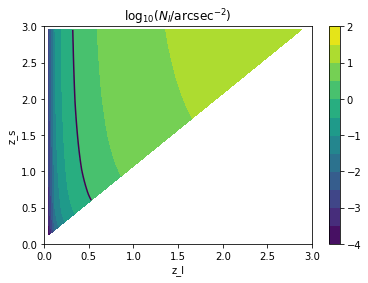

In [15]:
plt.contourf(np.log10(number_grid.T),
           origin='lower', extent=[zllist[0], zllist[-1], zslist[0], zslist[-1]],
            levels=np.arange(-4,2.1,.5))
plt.colorbar()
plt.contour(np.log10(number_grid.T),
           origin='lower', extent=[zllist[0], zllist[-1], zslist[0], zslist[-1]],
            levels=[0])
plt.xlabel('z_l')
plt.ylabel('z_s')
plt.xlim(0,3)
plt.ylim(0,3)
plt.title(r'$\log_{10}(N_I/\mathrm{arcsec^{-2}})$')

In particular for $z_l = 0.5$, $z_s = 1$, this comes out to

In [16]:
integral(.5, 1)

1.4933663762238345

Let's remember this number and compare with subhalos in the next section.

# Subhalo count

Now we'll do the same thing for subhalos.

Referencing the work we did in the [lensing overleaf](https://www.overleaf.com/project/5d68719c24d2c7071c21ca8e) in `subhalo_normalization.tex`, the number density of subhalos is given by:
$$\frac{d^2 N}{dmdA} = F m^{-1.9}$$
(area $A$ is already in physical units) where
$$F = \Sigma_{cr} \bar{\kappa}_\textit{sub} \frac{0.1}{m_\textit{high}^{0.1} - m_\textit{low}^{0.1}}$$
and $\bar{\kappa}_\textit{sub} = f_\textit{sub}/2$ for "moderately elliptical" lenses. Note that $m_\textit{high}$ and $m_\textit{low}$ are just the bounds of subhalo masses that get counted in $\bar{\kappa}_\textit{sub}$ (or equivalently $f_\textit{sub}$).

Integrating out to get $dN/dA$, we find
$$\frac{dN}{dA} = F \frac{m_l^{-.9} - m_h^{-.9}}{.9}$$
where $m_l$ and $m_h$ are the bounds of subhalos that we are actually interested in.

In [31]:
fsub = 4e-3 # more likely value according to arxiv:2006.07383
mhigh_fsub = 1e8 * u.Msun # don't mess with this value: this is the mass range used to define fsub
mlow_fsub = 1e5 * u.Msun  # (same here)
zl = 0.5 # Notice that we pick a fiducial zl and zs right away here (instead of making this a nice function suitable for a 2d graph).
zs = 1.0
dl = cosmo.angular_diameter_distance(zl)
ds = cosmo.angular_diameter_distance(zs)
dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
#print(dl, ds, dls)
sigma_cr = c.c**2 / (4*np.pi*c.G) * ds / (dl * dls)
kappa_bar = fsub / 2.
bigF = sigma_cr * kappa_bar * 0.1 / (mhigh_fsub**0.1 - mlow_fsub**0.1)
bigF = bigF.to(u.Msun**0.9 * u.kpc**-2) # physical kpc
print(bigF)

190963.54202053367 solMass(9/10) / kpc2


In [32]:
mh = m_high * u.Msun # use same mass range as interlopers
ml = m_low * u.Msun
#mh = 1e10 * u.Msun
#ml = 1e9 * u.Msun
number_per_area = bigF * (ml**-.9 - mh**-.9) / .9
print(number_per_area)

0.013175579327289147 1 / kpc2


In [33]:
area_in_as_sq = (arcsec_in_rad * dl)**2 # physical area
area_in_as_sq = area_in_as_sq.to(u.kpc**2)

In [34]:
number_in_as_sq = number_per_area * area_in_as_sq
number_in_as_sq

<Quantity 0.52220342>

So (with mass range $10^8$ to $10^{10}\,M_\odot$), the interloper number density is around 1.5 and the subhalo number density is around .5. This means we expect roughly 3x as many interlopers.

---
# Interloper count (accounting for effective mass)

Try redoing the count but this time counting interlopers whose effective mass falls within the range!

## Effective mass function

In [35]:
def meff_ratio(z_int, z_lens, z_source):
    def beta(i, j):
        dij = cosmo.angular_diameter_distance_z1z2(i, j)
        ds = cosmo.angular_diameter_distance(z_source)
        dj = cosmo.angular_diameter_distance(j)
        dis = cosmo.angular_diameter_distance_z1z2(i, z_source)
        return  dij * ds / (dj * dis)

    if z_int <= z_lens:
        f = 1 - beta(z_int, z_lens)
        g = 1
    else:
        f = 1 - beta(z_lens, z_int)
        g = f

    def sigcr(z):
        const = c.c**2 / (4 * np.pi * c.G)
        ds = cosmo.angular_diameter_distance(z_source)
        di = cosmo.angular_diameter_distance(z)
        dis = cosmo.angular_diameter_distance_z1z2(z, z_source)
        return const * ds / (di * dis)
    
    dl = cosmo.angular_diameter_distance(z_lens)
    di = cosmo.angular_diameter_distance(z_int)
    ratio = f * sigcr(z_lens) / sigcr(z_int) * (dl / (g * di))**2
    return ratio

Text(0, 0.5, 'Effective mass ratio')

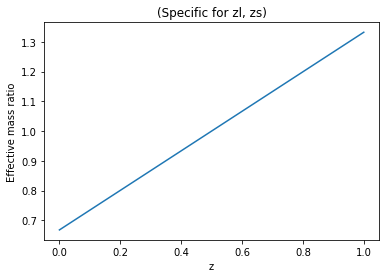

In [36]:
z_list = np.linspace(z_lower, 1 - z_lower, 20)
meff_ratios = [meff_ratio(z, .5, 1) for z in z_list]
plt.plot(z_list, meff_ratios)
plt.title('(Specific for zl, zs)')
plt.xlabel('z')
plt.ylabel('Effective mass ratio')

## New integral
The integral is almost the same as earlier. The only thing we change are the mass bounds on the inner integral:
$$N = R_\mathrm{ref}^2 \int_0^{z_s} dz \frac{d\chi}{dz} \frac{R^2(z)}{R^2(z_\ell)} \int_{m_l/\mu(z)}^{m_h/\mu(z)} n(z,m) dm$$
where:
- $\mu(z) = m_\mathrm{eff}/m$, the effective mass ratio.

So now, it's a bit of a shame because we need to recalculate the mass integral for every $z_l, z_s$ combination.

### New mass integral

In [37]:
mass_integral_list = [quad(lambda m: massfunc(z,m), m_low/meff_ratio(z, .5, 1), m_high/meff_ratio(z, .5, 1), epsrel=1e-2)[0]
                      for z in z_list]
mass_integral_func = interp1d(z_list, mass_integral_list)

Text(0, 0.5, 'Number density of all masses in range (/comoving volume; units?)')

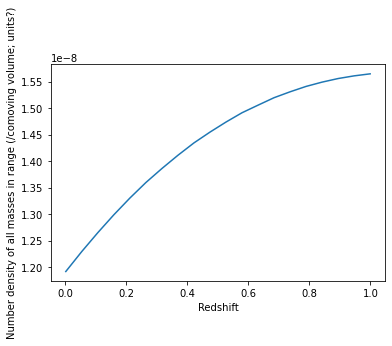

In [38]:
plt.plot(z_list, mass_integral_list)
plt.xlabel('Redshift')
plt.ylabel('Number density of all masses in range (/comoving volume; units?)') # per comoving kpc^3 I think?

In [39]:
def integrand(z, zl, zs):
    return dchi_dz_func(z) * double_cone_zspace(z, zl, zs)**2 * mass_integral_func(z)

def integral(zl, zs):
    rref = z_to_chi(zl) * arcsec_in_rad # one arcsec in comoving kpc (at the lens)
    return rref**2 * quad(lambda z: integrand(z, zl, zs), z_low, zs, epsrel=1e-2)[0]

In [40]:
integral(.5, 1)

1.4577459869805576